In [ ]:
import os

# TODO:根据自己的需求，屏蔽或启用GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import torch 
from torch import nn
import torchvision
import torch.utils.data as Data
import math

import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# TODO:把包的绝对路径改成你自己放包的路径
os.sys.path.append(r'E:\Raven\jupyter\Transfer Learning')
from tools import mmd
from tools import torch_plot
# from tools import data_loader as loader
from tools import load
from tools import resnet 

# 全局配置

包括文件路径，迭代次数，batch_size等

In [2]:
# 全局配置，包括文件路径等
root = r'E:\Raven\jupyter\Transfer Learning\Dateset\凯斯西储大学数据'
frequency = '12K'
classes = ('滚动体故障', '内圈故障', '外圈故障', '正常')
where = '风扇端'
source = '0HP'
target = '1HP'
batch_size = 32

# 加载数据

In [3]:
source_data, source_label = load.load_data(root, frequency, classes, source, where)
target_data, target_label = load.load_data(root, frequency, classes, source, where)

In [9]:
source_data.dataset.shape

torch.Size([320, 1, 64, 64])

# 构建网络

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16,  32,  3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,  32,  3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,  64,  3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,  128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Linear(256, 64),
#             nn.ReLU(),
#             nn.Linear(64, 16),
        )
         
    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.fc(x)

        return x

class Classificator(nn.Module):
    # 全连接层构成的分类器
    def __init__(self, num_classes=1):
        super().__init__()
        # resnet18的输出是512维的
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32 ),
            nn.ReLU(),
            nn.Linear(32 , num_classes)
        )
        
    def forward(self, inputs):
        return self.fc(inputs)


class IWAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = Net() # 共享权重的特征提取器
        self.D = Classificator()    # 领域鉴别器D
        self.D0 = Classificator()   # 领域鉴别器D0 
        self.classificator = Classificator(4)      # 分类器
        self.weight = None
        
    def forward(self, source, target=None):
        if self.training:
            # 特征提取：
            source_feature = self.feature_extractor(source)
            target_feature = self.feature_extractor(target)
            
            # 经过领域鉴别器，注意这里是一个二分类，激活函数要使用sigmoid,
            # 输出的结果可以看作是概率
            ps = torch.sigmoid(self.D(source_feature))
            pt = torch.sigmoid(self.D(target_feature))
            
            # 将源域数据加权，并将源域和目标域数据同时送入送D0
            self.weight = 1/(pt/(1-pt) + 1)
            weighted_source_feature = source_feature * self.weight
            ps_D0 = torch.sigmoid(self.D0(weighted_source_feature))
            pt_D0 = torch.sigmoid(self.D0(target_feature))
            
            # 源域数据送入分类器
            source_classificated = self.classificator(weighted_source_feature)
            
            return source_classificated, ps, pt, ps_D0, pt_D0
        
        # 测试时走这条路    
        else:
            # 特征提取
            target_feature = self.feature_extractor(source)
            # 加权
#             weighted_target_feature = target_feature * self.weight
            # 分类
            target_classificated = self.classificator(target_feature)
            
            return target_classificated
        

In [16]:
def train(dataloader, model):
    """
    dataloader:(source_data, source_label, target_data)构成的元组
    """
    lr = 1e-4
    optim_fe_and_cls = torch.optim.RMSprop([{'params':model.feature_extractor.parameters(),
                                          'params':model.classificator.parameters()}], 
                                          lr=lr, momentum=0.9)              # 用于优化特征提取器、分类器
    optim_D = torch.optim.RMSprop([{'params':model.D.parameters()}], 
                                    lr=lr, momentum=0.9)    # 用于优化领域鉴别器D 
    optim_D0 = torch.optim.RMSprop([{'params':model.D0.parameters()}], 
                                     lr=lr, momentum=0.9)  # 用于优化领域鉴别器D0
    
    size_source = len(dataloader[0].dataset)    # 源域的样本总量
    num_batches = len(dataloader[0])            # 源域的批数
    
    # 定义损失函数
    loss_fn_classification = nn.CrossEntropyLoss()     # 分类损失函数
    loss_fn_dicriminate = nn.BCELoss(reduction='mean') # 领域鉴别损失
    loss_fn_dicriminate0 = nn.BCELoss(reduction='mean')
    
    # 训练
    model.train()
    train_loss, correct, D_loss, D0_loss = 0, 0, 0, 0
    batch = 0
    for sourceData, sourceLabel, targetData in zip(dataloader[0], dataloader[1], dataloader[2]):
        X_source, y = sourceData.to(device), sourceLabel.to(device)
        X_target = targetData.to(device)
        
        # ---------------前向传播以及损失计算---------------
        pred, ps, pz, ps_D0, pt_D0 = model(X_source, X_target)     # 分类器输出, ps, pz, ps_D0, pt_D0
        classification_loss = loss_fn_classification(pred, y)      # 分类损失
        # 计算D的损失
        D_loss_source = loss_fn_dicriminate(ps, torch.ones((batch_size, 1)).to(device))  # D, 源域领域鉴别损失
        D_loss_tatget = loss_fn_dicriminate(pz, torch.zeros((batch_size, 1)).to(device)) # D, 目标域领域鉴别损失
        # 计算D0的损失
        D0_loss_source = loss_fn_dicriminate0(ps_D0, torch.ones((batch_size, 1)).to(device))  # D0, 源域领域鉴别损失
        D0_loss_tatget = loss_fn_dicriminate0(pt_D0, torch.zeros((batch_size, 1)).to(device)) # D0, 目标域领域鉴别损失
        # 总的训练损失
        train_loss += classification_loss.item() + \
                      D_loss_source.item() + \
                      D_loss_tatget.item() + \
                      D0_loss_source.item() + \
                      D0_loss_tatget.item()
    
        # 正确率
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        D_loss += D_loss_source.item() + D_loss_tatget.item()
        d_loss = D_loss_source + D_loss_tatget
        
        D0_loss += D0_loss_source.item() + D0_loss_tatget.item()
        d0_loss = D0_loss_source + D0_loss_tatget + classification_loss
        
        loss = classification_loss + D_loss_source + D_loss_tatget
        # ---------------反向传播---------------
        # 优化D0
        optim_D0.zero_grad()
        d0_loss.backward(retain_graph=True)    # 不清除梯度
        optim_D0.step()    
        
        # 优化特征提取器和分类器
        optim_fe_and_cls.zero_grad()
        classification_loss.backward(retain_graph=True)  # 不清除梯度
        optim_fe_and_cls.step()
        
        # 优化D
        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()
        
        batch += 1
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X_source)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size_source:>5d}]")
        
    train_loss /= num_batches
    correct /= size_source 
    D_loss /= num_batches
    
    return train_loss, correct, D_loss, D0_loss


def test(dataloader, model):
    """
    dataloader:(target_data, target_label)构成的元组
    """
    size = len(dataloader[0].dataset)
    num_batches = len(dataloader[0])
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    test_loss, correct, mmd_loss_ret = 0, 0, 0
    with torch.no_grad():
        for X, y in zip(dataloader[0], dataloader[1]):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            classification_loss = loss_fn(pred, y)      # 分类损失
#             loss = mmd_loss + classification_loss       # 总的损失
            
            test_loss += classification_loss.item()
#             mmd_loss_ret += mmd_loss
    
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
#     mmd_loss_ret /= num_batches
    
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct


In [ ]:
model = IWAN().to(device)


# print(model)   

epochs = 1000
train_losses = []
train_accs = []
train_mmd_losses = []

test_losses = []
test_accs = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc, train_mmd_loss, _ = train((source_data, source_label, target_data), model)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_mmd_losses.append(train_mmd_loss)
    
    # 测试模型
#     test_loss, test_acc = test((source_data, source_label), model)
    test_loss, test_acc = test((target_data, target_label), model)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

print("Done!")    

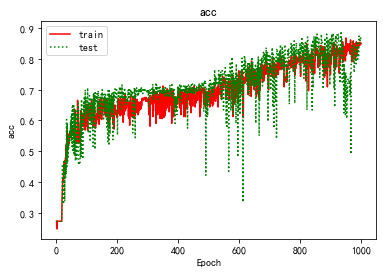

In [22]:
torch_plot.plot(train_accs, test_accs)

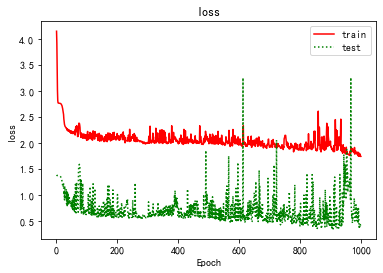

In [23]:
torch_plot.plot(train_losses, test_losses, dtype='loss')